Importu

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
dataframe = pd.read_json("vacancy_data.json", orient="records")

In [12]:
type(dataframe)

pandas.core.frame.DataFrame

In [13]:
dataframe.head()

,company_name,contract_type,description,introduction,job_category,location,vacancy_title
0,Enterprise,internship,Overview Add an annual turnover of $24 billio...,Unknown,management,Oxfordshire,12 Month Management Placement / Internship - O...
1,PWC,Unknown,Women in business Aiming for the top? Our Wome...,Unknown,,"Leeds, North Region UK",Women in Business Penultimate Year Assurance L...
2,Travel Lodge,parttime,Travelodge is expanding fast and we now have ...,Unknown,facility,Knutsford M6 Travelodge,Housekeeping Team Member - Part Time - 8 hour...
3,Nexus people,Temporary,Class 1 Driver – Bridgwater – Up to £17.00p/h ...,Unknown,logistics,Bridgwater,Class 1 Driver
4,Nexus people,Temporary,Warehouse Operative – Faverdale – Nights – Up...,Unknown,logistics,Darlington,Warehouse Operative


In [17]:
def transform_dataframe(dataframe):
    '''
    transform the data to new unit with ['label', 'text'] as columns
    '''
    columns = dataframe.columns.values
    return pd.melt(dataframe, value_vars=columns, var_name='label', value_name='text',)

melted_dataframe = transform_dataframe(dataframe)
melted_dataframe

,label,text
0,company_name,Enterprise
1,company_name,PWC
2,company_name,Travel Lodge
3,company_name,Nexus people
4,company_name,Nexus people
5,company_name,Sainsburys
6,company_name,Lidl
7,company_name,Dominos
8,company_name,Superdrug
9,company_name,Superdrug


In [38]:
def remove_values(dataframe, value):
    '''
    The data has some 'unknown' values, as where the scrapetool didnt find any data for that category
    3997 rows contained an unknown value. introduction(2898), contract_type(1066), location(33)
    '''
    unknowns_df = dataframe[dataframe.text == value]
    print(f"Total {value} count: {unknowns_df.shape[0]}")
    print(f"Total {value} count per label: \n{unknowns_df['label'].value_counts()}")
    print(
    f'''

    removing missing values from the dataset

     ''')
    cleaned_df = dataframe[~dataframe.text.str.contains(value)]
    if cleaned_df[cleaned_df.text==value].shape[0] == 0: print(f"all '{value}' removed")
    print(f'Removed {dataframe.shape[0] - cleaned_df.shape[0]} {value}')
    return cleaned_df
          
cleaned_dataframe = remove_values(melted_dataframe, "Unknown")

Total Unknown count: 3997
Total Unknown count per label: 
introduction     2898
contract_type    1066
location           33
Name: label, dtype: int64


    removing missing values from the dataset

     
all 'Unknown' removed
Removed 3997 Unknown


In [39]:
def metrics(dataframe):
    '''
    Some metrics:
    - How many observations per label?
    - how many observations in total
    '''
    print(f"Observations per label: \n{dataframe['label'].value_counts()}")
    print(f"Total Observations: {dataframe.shape[0]}")

metrics(cleaned_dataframe)

Observations per label: 
company_name     3533
job_category     3533
description      3533
vacancy_title    3533
location         3500
contract_type    2467
introduction      635
Name: label, dtype: int64
Total Observations: 20734


In [42]:
def splitting_dataset(dataframe):
    '''
    Splitting the test and train dataset
    '''
    dataframe = dataframe.drop_duplicates()
    text = dataframe['text'].values
    y = dataframe['label'].values
    
    # ULTRAA REEEEEE
    #
    # clf = SVC(kernel='linear', C=1)
    # scores = cross_val_score(clf, text, y, cv=5)
    # print(scores)
    print(dataframe['text'].shape[0])
    print(dataframe['text'].unique().shape[0])
    #print(dataframe[dataframe['label'] == 'contract_type'])
    #text = dataframe.drop_duplicates()
    print(dataframe.groupby('label').nunique())
    #print(dataframe['text'].duplicated(keep='first').sum())
    #print(dataframe.loc[dataframe.duplicated(keep='first'), :])

    text_train, text_test, y_train, y_test = train_test_split(
            text, y, test_size=0.25, random_state=2)

    #print(text_test)
    return text_train, text_test, y_train, y_test

text_train, text_test, y_train, y_test = splitting_dataset(cleaned_dataframe)

4793
4790
               label  text
label                     
company_name       1    31
contract_type      1    12
description        1  1474
introduction       1    30
job_category       1    11
location           1  1703
vacancy_title      1  1532


In [43]:
def train_model(text_train, y_train, wanted_clf):
    '''
    training pipeline
    '''
    classifiers = {
              'NB': MultinomialNB(),
              'SVM': SVC(C=1.0, kernel='linear', degree=3, gamma='auto'),
              'SGD': SGDClassifier(),
              'LR': LogisticRegression()
              }

    model = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', classifiers[wanted_clf]),
                  ])
    
    # testing~~~~
    #vectorizer = CountVectorizer()
    #X = vectorizer.fit(text_train)
    #print(vectorizer.get_feature_names())
    #print(X[0])

    model.fit(text_train, y_train)

    #y_pred = model.predict(text_test)
    return model

model = train_model(text_train, y_train, "SGD")

In [44]:
def predictions(model, text_test):
    predictions = model.predict(text_test)
    return predictions

y_pred = predictions(model, text_test)

In [45]:
def scoring(y_pred, y_test):
    accuracy = 'accuracy %s' % accuracy_score(y_pred, y_test)
    columns = ['company_name','contract_type','description','introduction','job_category','location','vacancy_title']
    print(classification_report(y_test, y_pred,target_names=columns))
    return accuracy, report

accuracy, report = scoring(y_pred, y_test)


               precision    recall  f1-score   support

 company_name       0.00      0.00      0.00         9
contract_type       0.00      0.00      0.00         1
  description       0.99      0.99      0.99       392
 introduction       1.00      0.67      0.80         6
 job_category       1.00      0.50      0.67         2
     location       0.94      0.99      0.97       404
vacancy_title       0.99      0.97      0.98       385

    micro avg       0.97      0.97      0.97      1199
    macro avg       0.70      0.59      0.63      1199
 weighted avg       0.97      0.97      0.97      1199



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
def kijkdoos(text_test, y_test, y_pred):
    d = {'Text': text_test, 'Label': y_test, 'Predicted': y_pred}
    df = pd.DataFrame(d)
    print(df[df.Label != df.Predicted].sample(n=20))

kijkdoos(text_test, y_test, y_pred)

                                                   Text          Label  \
84                                              Optical  vacancy_title   
695                                            Red Bull   company_name   
595                                             Primark   company_name   
840                                               Cook   vacancy_title   
189                                         traineeship  contract_type   
554                                                        description   
205                                        River Island   company_name   
206                                              Greggs   company_name   
90    Administrator - Personnel (Recruitment) - 20 h...  vacancy_title   
831   Location: Manchester M2 4EW  About the role   ...    description   
349                                        Nexus people   company_name   
1185                                   personal shopper  vacancy_title   
181                                   

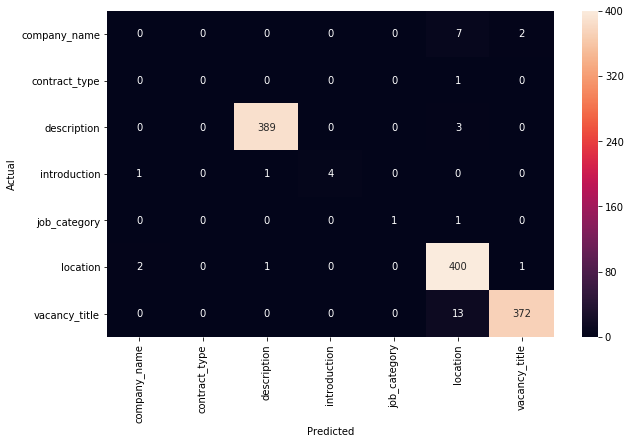

In [47]:
def visualisations(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    #print(conf_mat)
    columns = ['company_name','contract_type','description','introduction','job_category','location','vacancy_title']
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
        xticklabels=columns, yticklabels=columns)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    #plt.savefig(f'figure-{timestamp}.png')
    plt.show()
    plt.close()
    
visualisations(y_test, y_pred)

![gif](https://media.giphy.com/media/rAm0u2k17rM3e/giphy.gif "help")